# 1. Setup

## 1.1 Install Dependencies

In [2]:
!pip install tensorflow==2.13.0 opencv-python matplotlib

zsh:1: /Users/chuamingfeng/Desktop/FaceID/faceid/bin/pip: bad interpreter: /Users/chuamingfeng/Desktop/Facial_Recognition/faceid/bin/python3.11: no such file or directory


  Obtaining dependency information for tensorflow==2.13.0 from https://files.pythonhosted.org/packages/86/a3/a6ffba31621a402d12b137e656814c7b8de2f796fa976acbe92f4602ebad/tensorflow-2.13.0-cp311-cp311-macosx_10_15_x86_64.whl.metadata
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/8a/6f/8aa049b66bcba8b5a4dc872ecfdbcd8603a96704b070fde22222e479c3d7/opencv_python-4.8.0.76-cp37-abi3-macosx_10_16_x86_64.whl.metadata
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import tensorflow dependencies with tensorflow Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2023-09-03 19:02:19.104832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.3 Set GPU Growth

## 1.4 Create Folder Structure

In [21]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset
http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW images to the following repository data/negative
for directory in os.listdir('lfw'):
    if directory != '.DS_Store':
        for file in os.listdir('lfw/' + directory):
            EX_PATH = os.path.join('lfw/', directory, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [18]:
# Import uuid library to generate unique image names
import uuid

In [22]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:120+250, 650:650+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Shows image on the screen
    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [26]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

In [32]:
dir_test = anchor.as_numpy_iterator()

In [33]:
dir_test.next()

b'data/anchor/e1ea2268-4992-11ee-9e28-acde48001122.jpg'

## 3.2 Preprocessing - Scale and Resize

In [40]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img =  tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing - resizing the image to be 105x105x3
    img = tf.image.resize(img, (105,105))
    # Scale image to between 0 and 1
    img = img/255.0
    return img

In [53]:
img = preprocess('data/anchor/e1ea2268-4992-11ee-9e28-acde48001122.jpg')

In [42]:
img

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.5254902 , 0.4117647 , 0.28627452],
        [0.5294118 , 0.41512603, 0.28991598],
        [0.51856965, 0.39700103, 0.27543238],
        ...,
        [0.05583568, 0.04799255, 0.0562092 ],
        [0.05788982, 0.05732961, 0.06545284],
        [0.03893998, 0.03893998, 0.04678312]],

       [[0.52408296, 0.41035748, 0.28430706],
        [0.5291516 , 0.41514605, 0.2885754 ],
        [0.5261438 , 0.4084967 , 0.27516338],
        ...,
        [0.08085902, 0.0731426 , 0.07668403],
        [0.08209284, 0.08153263, 0.08909567],
        [0.05376812, 0.05396153, 0.06180467]],

       [[0.5185808 , 0.40485528, 0.27152196],
        [0.5203548 , 0.4063492 , 0.2730159 ],
        [0.5268352 , 0.40918812, 0.2758548 ],
        ...,
        [0.08315548, 0.07467876, 0.07762887],
        [0.07102173, 0.06881419, 0.08157264],
        [0.04835485, 0.04806362, 0.06122889]],

       ...,

       [[0.18947133, 0.18554977, 0.17770663],
        [0.18

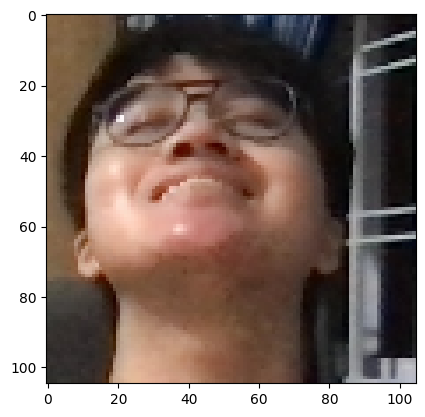

In [43]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [45]:
# (anchor, positive) -> 1,1,1,1,1
# (anchor, negative) -> 0,0,0,0,0

In [50]:
positives = tf.data.Dataset.zip(
    (
        anchor, 
        positive, 
        tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))
        )
)

negatives = tf.data.Dataset.zip(
    (
        anchor, 
        negative, 
        tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))
        )
)

data = positives.concatenate(negatives)

In [54]:
samples = data.as_numpy_iterator()

In [57]:
example = samples.next()
example

(b'data/anchor/e174e75a-4992-11ee-9e28-acde48001122.jpg',
 b'data/positive/f7303d10-4992-11ee-9e28-acde48001122.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [58]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [59]:
preprocess_twin(*example)

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.58889115, 0.47124407, 0.3300676 ],
         [0.5928038 , 0.48299986, 0.3373416 ],
         [0.58618116, 0.47637722, 0.32343602],
         ...,
         [0.06722687, 0.07292247, 0.07544352],
         [0.06900761, 0.07292918, 0.08077232],
         [0.04519359, 0.04519359, 0.05303672]],
 
        [[0.60755634, 0.48906896, 0.3481726 ],
         [0.6084033 , 0.48991597, 0.34901962],
         [0.6046352 , 0.48652795, 0.34550488],
         ...,
         [0.08083234, 0.08842205, 0.08107914],
         [0.08291316, 0.08711483, 0.09411766],
         [0.05454176, 0.05724951, 0.06509264]],
 
        [[0.6228647 , 0.4916789 , 0.3508759 ],
         [0.60999066, 0.48235294, 0.3397759 ],
         [0.61196923, 0.487246  , 0.34369746],
         ...,
         [0.08352897, 0.08352897, 0.083529  ],
         [0.09725892, 0.0979125 , 0.11023746],
         [0.05496193, 0.0588835 , 0.07027472]],
 
        ...,
 
        [[0.26515055, 0.24946427

In [60]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [101]:
# Training partition
train_data = data.take(
    round(len(data)*.7)
    )
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [110]:
# Testing partition
test_data = data.skip(
    round(len(data)*.7)
    )
test_data = test_data.take(
    round(len(data)*.3)
    )
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [119]:
def build_embedding():
    inp = Input(shape=(105,105,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [125]:
embedding = build_embedding()

In [126]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 18, 18, 128)       26

## 4.2 Build Distance Layer

In [122]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, anchor_embedding, validation_embedding):
        return tf.math.abs(anchor_embedding - validation_embedding)

In [123]:
l1 = L1Dist()

## 4.3 Build Siamese Model

In [127]:
def build_siamese_nets():

    # Anchor image
    input_image = Input(name='input_img', shape=(105,105,3))
    # Validation image
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNN')

In [131]:
siamese_model = build_siamese_nets()

In [132]:
siamese_model.summary()

Model: "SiameseNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                          

# 5. Training

## 5.1 Setup Loss and Optimizer

In [135]:
bce_loss = tf.losses.BinaryCrossentropy()

In [136]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [137]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [153]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        # Get anchor and validation image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        y_pred = siamese_model(X, training=True)
        # Calculate loss
        loss = bce_loss(y, y_pred)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to model
    opt.apply_gradients(
        zip(grad, siamese_model.trainable_variables)
        )
    return loss

## 5.4 Build Training Loop

In [154]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the Model

In [155]:
EPOCHS = 50

In [156]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 297s 11s/step

 Epoch 2/50
27/27 [==============================] - 259s 10s/step

 Epoch 3/50
27/27 [==============================] - 248s 9s/step

 Epoch 4/50
27/27 [==============================] - 246s 9s/step

 Epoch 5/50
27/27 [==============================] - 248s 9s/step

 Epoch 6/50
27/27 [==============================] - 246s 9s/step

 Epoch 7/50
27/27 [==============================] - 242s 9s/step

 Epoch 8/50
27/27 [==============================] - 241s 9s/step

 Epoch 9/50
27/27 [==============================] - 245s 9s/step

 Epoch 10/50
27/27 [==============================] - 251s 9s/step

 Epoch 11/50
27/27 [==============================] - 259s 9s/step

 Epoch 12/50
27/27 [==============================] - 246s 9s/step

 Epoch 13/50
27/27 [==============================] - 242s 9s/step

 Epoch 14/50
27/27 [=========================

# 6. Evaluate Model

## 6.1 Import Metrics

In [157]:
# Import metrics
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [215]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [216]:
y_pred = siamese_model.predict([test_input, test_val])
y_pred

1/1 [==============================] - 2s 2s/step


array([[9.98047948e-01],
       [1.68451134e-05],
       [8.17222823e-09],
       [1.00000000e+00],
       [4.10832826e-07],
       [1.12294965e-05],
       [3.54100216e-08],
       [9.98346746e-01],
       [9.98038054e-01],
       [9.99996424e-01],
       [4.30823229e-06],
       [2.37500029e-08],
       [9.99912918e-01],
       [5.88913522e-08],
       [1.00000000e+00],
       [1.00000000e+00]], dtype=float32)

In [217]:
[1 if pred > 0.5 else 0 for pred in y_pred]

[1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]

In [218]:
y_true

array([1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [183]:
# Create metric object
m = Recall()
# Calculate recall value
m.update_state(y_true, y_pred)
# Return recall result
m.result().numpy()

1.0

In [184]:
# Create metric object
m = Precision()
# Calculate precision value
m.update_state(y_true, y_pred)
# Return precision result
m.result().numpy()

1.0

## 6.4 Viz

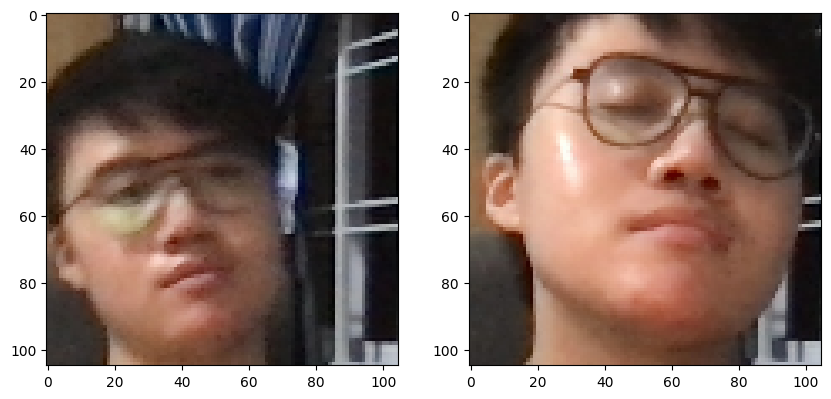

In [192]:
# Set plot size
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[7])
plt.subplot(1,2,2)
plt.imshow(test_val[7])
plt.show()

# 7. Save Model

In [194]:
# Save weights
siamese_model.save('siamesemodel.h5')

/Users/chuamingfeng/Desktop/FaceID/faceid/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [237]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                    custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [238]:
model.predict([test_input,test_val])

1/1 [==============================] - 2s 2s/step


array([[9.98047948e-01],
       [1.68451134e-05],
       [8.17222823e-09],
       [1.00000000e+00],
       [4.10832826e-07],
       [1.12294965e-05],
       [3.54100216e-08],
       [9.98346746e-01],
       [9.98038054e-01],
       [9.99996424e-01],
       [4.30823229e-06],
       [2.37500029e-08],
       [9.99912918e-01],
       [5.88913522e-08],
       [1.00000000e+00],
       [1.00000000e+00]], dtype=float32)

# 8. Real Time Test

## 8.1 Verification Function

In [239]:
def verify(model, detection_threshold, verification_threshold):

    """
    model: siamese model
    detection_threshold: metric above which a prediction is classified as positive
    verification_threshold: proportion of positive predictions / total positive samples
    """

    results = []
    verification_images = os.listdir(os.path.join('application_data', 'verification_images'))
    for image in verification_images:
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)), verbose = 0)
        results.append(result)
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection/len(verification_images)

    return results, verification > verification_threshold

## 8.2 OpenCV Real Time Verification

In [293]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:120+250, 650:650+250, :]

    cv2.imshow('Verification', frame)

    # Frame verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # save input image to application_data/input_image
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(model, 0.5, 0.7)
        print(verified)
        print(np.sum(np.squeeze(results) > 0.5))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [290]:
np.squeeze(results)

array([9.98567045e-01, 4.84989141e-06, 3.90553653e-01, 5.18380781e-04,
       2.81678498e-01, 1.00000000e+00, 9.47166026e-01, 4.62630342e-05,
       2.23492854e-04, 9.99997139e-01, 2.90928900e-01, 1.00000000e+00,
       5.25153791e-06, 9.99985456e-01, 1.61451194e-03, 7.81443396e-06,
       7.19162226e-01, 9.96927321e-01, 4.08175129e-06, 3.64242494e-02,
       9.99319792e-01, 2.19850830e-04, 9.99880910e-01, 1.14599830e-02,
       9.51398306e-06, 9.76375937e-01, 6.86571366e-06, 9.99873102e-01,
       9.98393834e-01, 1.66767428e-03, 1.71037505e-06, 9.75624084e-01,
       2.22860717e-06, 9.87355709e-01, 3.30618203e-01, 9.98932719e-01,
       1.54809220e-06, 9.62190607e-05, 2.11642802e-01, 9.98993456e-01,
       1.61157259e-05, 4.50451404e-01, 8.51489186e-01, 3.54320332e-02,
       5.72688748e-07, 9.99422014e-01, 2.22992213e-07, 1.09833344e-07,
       9.99997437e-01, 9.33209717e-01], dtype=float32)

In [273]:
np.sum(np.squeeze(results) > 0.5)

18

In [246]:
def is_image(filename, verbose=False):

    data = open(filename,'rb').read(10)

    # check if file is JPG or JPEG
    if data[:3] == b'\xff\xd8\xff':
        if verbose == True:
             print(filename+" is: JPG/JPEG.")
        return True

    # check if file is PNG
    if data[:8] == b'\x89\x50\x4e\x47\x0d\x0a\x1a\x0a':
        if verbose == True:
             print(filename+" is: PNG.")
        return True

    # check if file is GIF
    if data[:6] in [b'\x47\x49\x46\x38\x37\x61', b'\x47\x49\x46\x38\x39\x61']:
        if verbose == True:
             print(filename+" is: GIF.")
        return True

    return False

In [282]:
for filename in os.listdir(os.path.join('application_data', 'verification_images')):
     # check if file is actually an image file
     if is_image(os.path.join('application_data', 'verification_images', filename), verbose=False) == False:
          # if the file is not valid, remove it
          os.remove(os.path.join(os.path.join('application_data', 'verification_images'), filename))